In [ ]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import shutil
os.chdir("/home/149/ab8992/topographic-NIWs")
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
import autolib as al
from dask.distributed import Client
# client = Client()
client = Client()
client

: 

In [2]:
data = xr.open_dataset("/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-1/archive/output001/e_10min.nc",chunks = ({"xh":50,"yh":50})).sel(yh = slice(-1600,-1400)).isel(time = 115).e

zon_anom = (data - data.mean("xh")).isel(zi = -2).sel(xh = slice(-200,200))
merid = data.isel(zi = 1).sel(xh = slice(-200,200)) + 800
topog = data.isel(zi = -1).sel(xh = slice(-200,200))

merid = (merid * 0) + merid.mean("xh")

# topog.plot()
# plt.figure()
# zon_anom.plot()
# plt.figure()
# merid.plot()
def normalise(x):
    return (x - x.min()) / (x.max() - x.min())

def interp(z,xfac = 10,yfac = 10):

    xnew = np.linspace(z.xh[0],z.xh[-1],round(z.xh.shape[0]*xfac))
    ynew = np.linspace(z.yh[0],z.yh[-1],round(z.yh.shape[0]*yfac))
    znew = z.interp(xh = xnew,yh = ynew)
    return znew

Z_zonal = normalise(zon_anom) * 2
Z_merid = -1 * normalise(merid) + 4.5
Z_topog = normalise(topog) - 2

# # Interpolate Z variables onto higher resolution grids using scipy
#Flip merid for aesthetic purposes

Z_topog = interp(Z_topog,xfac = 10,yfac = 0.05).persist()
# Z_zonal = interp(Z_zonal,xfac = 5,yfac = 5).persist()
# Z_merid = interp(Z_merid,xfac = 0.01,yfac = 10).persist()

# Lower Res for fast plotting
# Z_topog = interp(Z_topog,xfac = 0.5,yfac = 0.05).persist()
Z_zonal = interp(Z_zonal,xfac = 0.5,yfac = 0.5).persist()
Z_merid = interp(Z_merid,xfac = 0.1,yfac = 0.5).persist()


## Make Hovmöller and spectral plot

In [5]:
path = "duration_ridge_20layer/duration_ridge_20layer_duration-1"

def horizontal_eslice(path,dim = "xh",var = "e",vcoord = "zi"):
    eslice = xr.open_mfdataset(
        f"/home/149/ab8992/bottom_near_inertial_waves/revision/{path}/archive/output00*/{var}_10min.nc",chunks = {dim:500,"time":500},decode_times = False,parallel=True).isel({"yh" : 250,"time" : slice(0,4152//2),"zi" : 13})


    eslice = eslice[var].assign_coords({"time":("time",eslice.time.values * 60),
                            dim:(dim,eslice[dim].values * 1000)
        })

    eanom = (eslice - eslice.mean(dim)).load()
    eslice.close()
    eanom_flipped = xr.DataArray(
        data = eanom[::-1,:],
        coords = [600 - eanom.time[::-1],eanom[dim]],
        dims = ["time",dim]
    )

    extended = xr.concat([eanom_flipped,eanom],dim = "time")

    ###  COMBINE INTO ONE FUNCTIon
    strat = 1
    if "strat" in path:
        strat = float(path.split("-")[-1])

    print("loading")
    e = extended.load()
    print("done")
    spectrum = xrft.power_spectrum(e,dim=["time",dim],true_phase = True,true_amplitude = True)

    ## Commentted out include spectrum in saved files
    out = xr.Dataset(
        {"spectrum":spectrum.sel({"freq_time" : slice(0,None),f"freq_{dim}" : slice(0,None)}),"slice":eslice}
    )

    return out

data = horizontal_eslice(path,dim = "xh",var = "e",vcoord = "zi")

data["slice"].to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/20layerhovmoller_for_figure.nc")
data["spectrum"].to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/20layerspectrum_for_figure.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xh" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


loading
done


In [6]:
spectrum = xr.open_dataarray("/g/data/v45/ab8992/bottom_iwbs/20layerspectrum_for_figure.nc").persist()
eslice = xr.open_dataarray("/g/data/v45/ab8992/bottom_iwbs/20layerhovmoller_for_figure.nc").persist()

def omega(k,f,N,n,H,l = 0):
    f = np.full(k.shape,f)
    N = np.full(k.shape,N)
    n = np.full(k.shape,n)
    H = np.full(k.shape,H)
    l = np.full(k.shape,l)
    K2 = k**2 + l**2
    
    m = np.pi * n / H
    num = f**2 * m**2 + K2 * N ** 2
    den = K2 + m ** 2
    return np.sqrt(num / den)


def vmodes(k,n):
    k = k
    f = 0.0001 / (np.pi * 2)
    N = np.sqrt((2 * 9.8) / (3275 * 1027))  # N in s^-1
    # N = np.sqrt((2 * 9.8) / (4000 * 1027))  # N in s^-1
    print(f / N)
    m = np.pi * n / 4000
    K2 = 2 * k**2
    num = f**2 * m**2 + K2 * N ** 2
    den = m ** 2
    return np.sqrt(num / den)

# k = spectrum.freq_xh.values
# n = 1
# fig,ax = plt.subplots(1,figsize = (10,10))
# plt.plot(k,vmodes(k,n),color = "red")
# plt.plot(k,vmodes(k,2),color = "red")
# plt.plot(k,vmodes(k,3),color = "red")
# np.log(spectrum.sel(freq_xh = slice(0,6e-5),freq_time = slice(0,0.8e-4))).plot(cmap = cmap1,vmin = 2,vmax = 15,add_colorbar = False, ax = ax)


0.006592998393590467
0.006592998393590467
0.006592998393590467


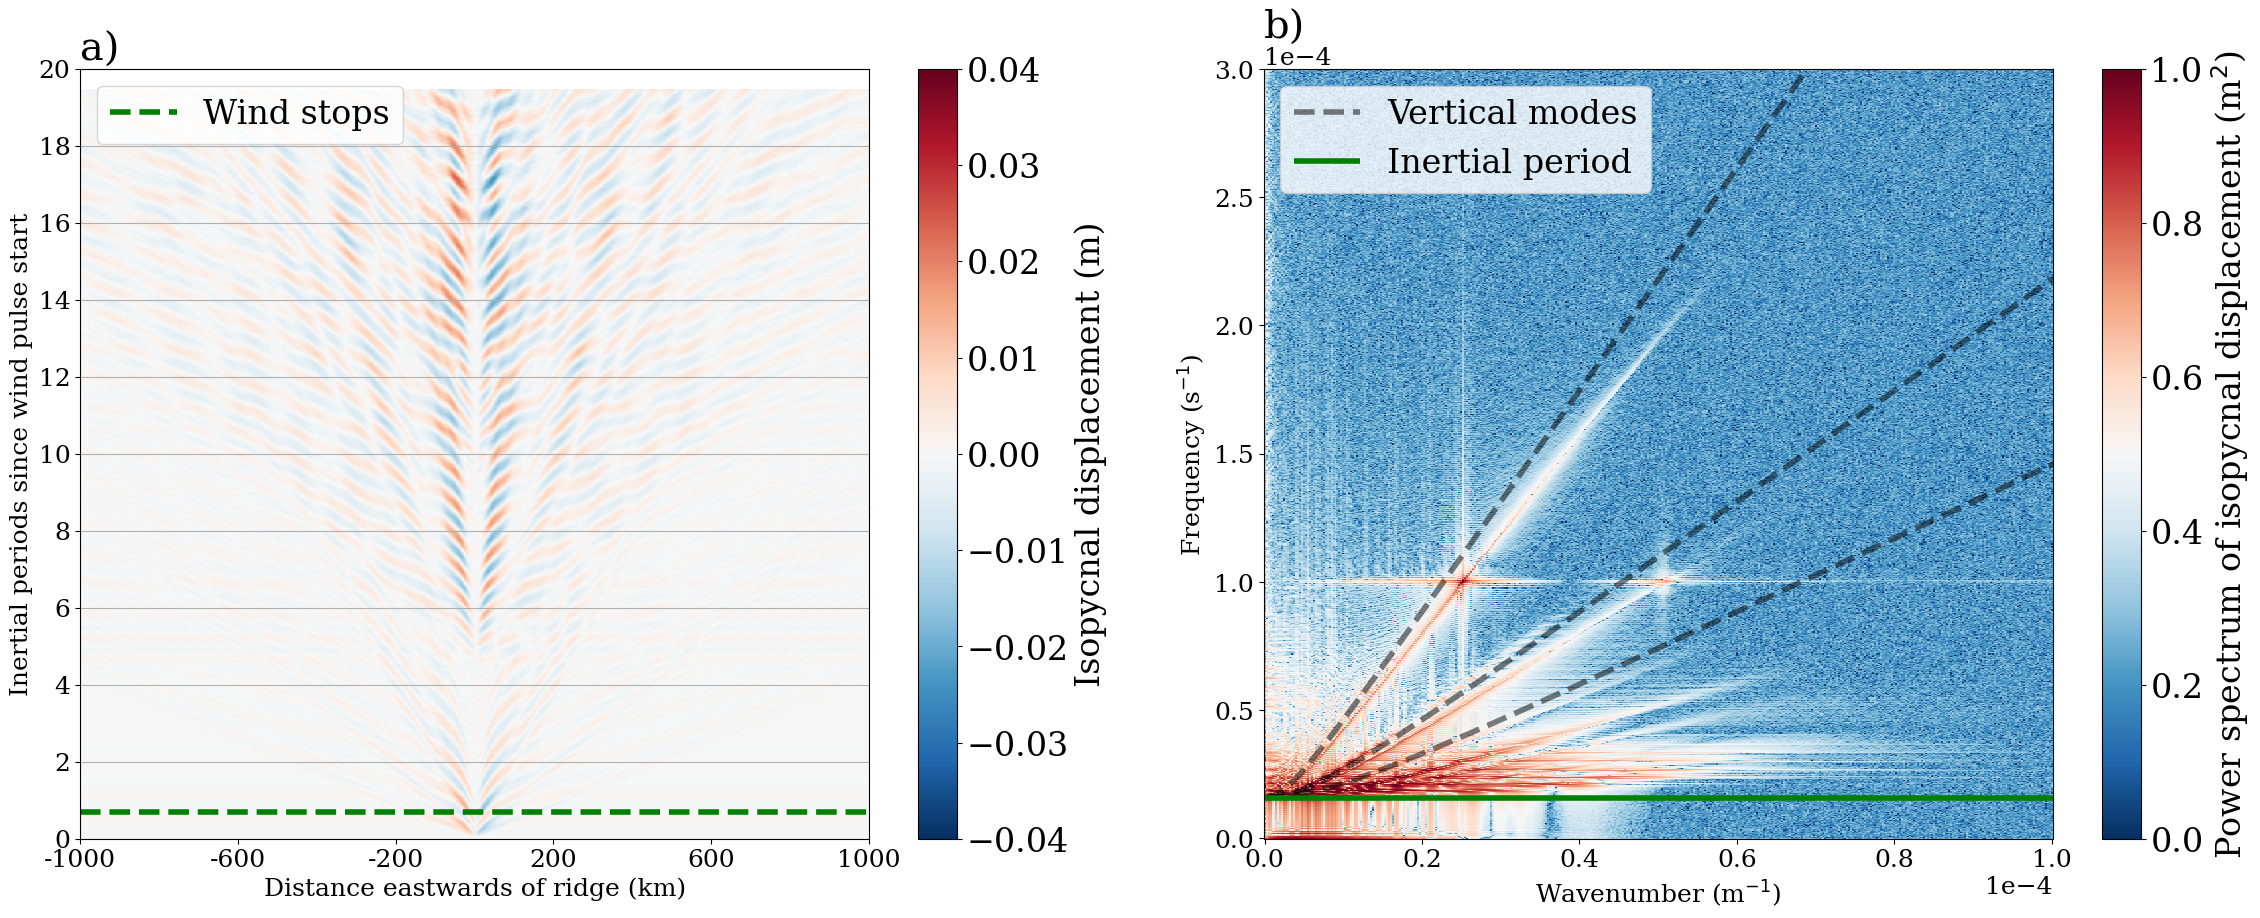

In [7]:
fig,ax = plt.subplots(1,2,figsize = (28,10))
cmap0 = matplotlib.cm.RdBu_r
cmap1 = sns.color_palette("rocket_r", as_cmap=True)
cmap1 = sns.cubehelix_palette(start=.75, rot=-1, as_cmap=True,light = 1)
cmap1 = "RdBu_r"
fp = (2 * np.pi / 0.0001) 
fp_hours = fp * 3600
# plot without colorbar 

vmin_s = -20
vmax_s = 17
vmin_s = -10
vmax_s = None
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 24}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
lw = 4

freq_xhlim = 1e-4
freq_timelim = 3e-4
xmin = -1000000
xmax = 1000000

np.log(spectrum.sel(freq_xh = slice(0,freq_xhlim),freq_time = slice(0,freq_timelim))).plot(cmap = cmap1,vmin = vmin_s,vmax = vmax_s,ax = ax[1],add_colorbar = False)



ax[1].plot(spectrum.freq_xh.values,vmodes(spectrum.freq_xh.values,1),color = "black",lw = lw,linestyle = "--",alpha = 0.5,label = "Vertical modes")
for i in range(2,4):
    ax[1].plot(spectrum.freq_xh.values,vmodes(spectrum.freq_xh.values,i),color = "black",lw = lw,linestyle = "--",alpha = 0.5)
(eslice - eslice.isel(time = 0)).sel(xh = slice(xmin,xmax)).plot(ax = ax[0],vmin = -0.04,vmax = 0.04,cmap = "RdBu_r",add_colorbar = False)
ax[1].hlines(0.0001 / (np.pi * 2),0,0.00014,color = "green",lw = lw,linestyle = "-",label = "Inertial period")
times = np.array([0,24,48,72,96])
times = np.linspace(0,20,11)
lons = np.linspace(-1000000,1000000,6)

ax[0].set_xlabel("Distance eastwards of ridge (km)")
ax[0].set_ylabel("Inertial periods since wind pulse start")
ax[0].set_title("")
ax[0].set_yticks(times * fp)
ax[0].set_yticklabels((times).astype(int))
ax[0].set_ylim((-1,None))
ax[0].grid(axis = "y")
ax[0].set_xticks(lons)
ax[0].set_xticklabels((lons / 1000).astype(int))
ax[0].hlines(12 * 3600,-1000000,1000000,color = "green",lw = lw,linestyle = "--",label = "Wind stops")
## Colorbar 0
# set location of legend to lower left
ax[0].set_title("a)",loc = "left") 
ax[0].legend(loc = "upper left")
ax[1].set_title("b)",loc = "left")

norm0 = matplotlib.colors.Normalize(vmin=-0.04, vmax=0.04)
norm1 = matplotlib.colors.Normalize(vmin=vmin_s, vmax=vmax_s)

plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap0),ax = ax[0],label = f"Isopycnal displacement (m)",orientation = "vertical")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap=cmap1),ax = ax[1],label = f"Power spectrum of isopycnal displacement (m$^2$)",orientation = "vertical")
ax[1].legend()
ax[1].set_xlabel(r"Wavenumber (m$^{-1}$)")
ax[1].set_ylabel(r"Frequency (s$^{-1}$)")
ax[1].set_title("")
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(-5,-4))

# 4 Frame Snapshots

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
cmap = "coolwarm"
framedim = "time"
import seaborn as sns



data = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/zonal/*.nc",decode_times = False,decode_cf = False)

data_e = data.e
data_u = data.u.interp(xq = data_e.xh).drop("xq")

data_u = (data_u - data_u.mean("xh")).sel(xh = slice(-200,200))
data_e = data_e.sel(xh = slice(-200,200))
data_e = data_e.mean("yh").load()
data_u = data_u.mean("yh").load()



def snapshot(time,ax):
    tt = time
    vmax = data_u.isel(time = tt).max().values * 1
    vmax = 0.0004
    vmin = -1 * vmax
    scaling = 2000 # Scale the anomaly in interface height
    x = data_u.xh
    mean_depths = data_e.isel(time = 0)
    base = mean_depths.isel(zi = 0)
    deviation = (data_e.isel(time = tt).isel(zi = 0) - mean_depths[0,:])
    layer = base + deviation * scaling
    layer.plot(ax = ax,color = "blue",linewidth = 2)
  

    for i in range(0,20):
        prev_layer = layer
        if i == 10:
            scaling = 1500
        if i == 13:
            scaling = 1000
        if i == 15:
            scaling = 200
        ## Plot this layer 
        base = mean_depths.isel(zi = i+1)
        deviation = (data_e.isel(time = tt).isel(zi = i+1) - mean_depths.isel(zi = i+1))
        layer = base + deviation * scaling
        layer.plot(ax = ax,color = "black",linewidth = 1)


        # Create patch for the clipping of velocity field to fill space between layers. See https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
        
        # verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer * 0 + 4000)], 1)]) ## creates vertices 
        verts = np.vstack([np.stack([x, prev_layer], 1), np.stack([np.flip(x), np.flip(layer)], 1)]) ## creates vertices 
        path = Path(verts)
        patch = PathPatch(path, lw = 2,transform=ax.transData) ## patch to clip the velocity field

        # Plot velocity field and apply patch as clip path
        velfield = data_u.isel(time = tt,zl = i).expand_dims({"vert":2},axis = 1)
        X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],x.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
        im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
        im.set_clip_path(patch)

    
    
    ## Handle bottom layer case
    prev_layer = layer
    layer = data_e.isel(time = 0,zi = -1)
    
    layer.plot(ax = ax,color = "green",linewidth = 1)
    
    verts = np.vstack([np.stack([x, layer], 1), np.stack([np.flip(x), np.flip(prev_layer)], 1)])
    path = Path(verts)
    
    patch = PathPatch(path, lw = 2,transform=ax.transData)
    
    # Plot bottom layer velocity
    velfield = data_u.isel(time = tt,zl = -1).expand_dims({"vert":2},axis = 1) 
    X,Y = np.meshgrid(np.linspace(x[0].values.reshape(1)[0],x[-1].values.reshape(1)[0],data_u.xh.shape[0]),np.linspace(prev_layer.max().values.reshape(1)[0],layer.min().values.reshape(1)[0],2))
    im = ax.pcolormesh(X, Y, velfield.T,cmap = cmap,vmin = vmin,vmax = vmax)
    im.set_clip_path(patch)
    ax = plt.gca()
    ax.set_ylim([-4000,10])


    
    return ax
    

fig,axes = plt.subplots(2,2,figsize = (15,12),sharey = True,sharex=True)


start = 10 # hours. Next convert to timesteps/ 3 per hour
start *= 3

## Get inertial period
fp = (2 * np.pi / 0.0001) / 3600
print(fp)
fp_10mins = fp * 3

captions = ["a) t = 10 hrs (End of storm)","b) + 0.5 inertial periods","c) + 1 inertial period","d) + 1.5 inertial periods"]

# for i,time in enumerate([30,60,120,180]):
for i,time in enumerate([start,start + round(fp_10mins * 0.5),start + round(fp_10mins * 1),start + round(fp_10mins * 1.5)]):
    print(i,time)
    snapshot(time,axes[i//2,i%2])
    axes[i//2,i%2].set_title("")

    axes[i//2,i%2].set_title(captions[i],loc = "left")


    axes[i//2,i%2].set_xlabel("Longitude (km)")
    axes[i//2,i%2].set_ylabel("Depth (m)")
    axes[i//2,i%2].set_yticklabels([4000,3000,2000,1000,0])
    axes[i//2,i%2].set_yticks([-4000,-3000,-2000,-1000,0])
    if i%2 != 0:
        axes[i//2,i%2].set_ylabel("")
    if i//2 != 1:
        axes[i//2,i%2].set_xlabel("")

    # break

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = matplotlib.colors.Normalize(vmin=-1e-1, vmax=1e-1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="coolwarm"),cax = cbar_ax,label = f"Zonal Velocity (mm/s)")
cbar.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar.set_ticklabels([-0.1,-0.05,0,0.05,0.1])




# Movie

In [3]:



def make_movie(data,plot_function,framerate = 20,parallel = False,plot_kwargs = {}):
    """
    Custom function to make a movie of a plot function. Saves to a folder in dropbox. Intermediate frames are saved to /tmp
    data_list : dictionary of dataarrays required by plot function
    plot_function : function to plot data
    runname : name of the run eg full-20
    plotname : name of the plot eg "h_energy_transfer"
    plot_kwargs : kwargs to pass to plot function
    """
    from pathlib import Path
    runname = "20layer"
    plotname = "movie"
    tmppath = Path(f"/g/data/v45/ab8992/movies_tmp/bottomiws")
    outpath = Path(f"/g/data/v45/ab8992/dropbox/bottomiw_movies/{runname}")
    print(tmppath)
    ## Log the start of movie making

    if os.path.exists(tmppath):
        shutil.rmtree(tmppath)
    os.makedirs(tmppath)
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    


    ## Make each frame of the movie and save to tmpdir
    if parallel == True:
        # @dask.delayed
        # def process_chunk(_data,i):
        #     fig = plot_function(_data,**plot_kwargs)
        #     fig.savefig(tmppath / f"frame_{str(i).zfill(5)}.png")
        #     plt.close()
        #     return None
        
        # frames = [process_chunk(data.isel(time = i),i) for i in range(len(data.time))]
        # dask.compute(*frames)
        pass

    ## Do the same thing but in serial
    else:
        for i in range(len(data.time)):
            fig = plot_function(data.isel(time = i))
            fig.savefig(tmppath / f"frame_{str(i).zfill(5)}.png")
            plt.close()


    print(f"Finished making frames")
    print(f"ffmpeg -r {framerate}  -i {tmppath}/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p {str(outpath) + plotname}.mp4")
    result = subprocess.run(
            f"ffmpeg -y -r {framerate} -i {tmppath}/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p {str(outpath / plotname)}.mp4",
            shell = True,
            capture_output=True,
            text=True,
        )
    print(f"ffmpeg finished with returncode {result.returncode} \n\n and output \n\n{result.stdout}")
    print(
        f"ffmpeg finished with returncode {result.returncode}",
    )
    print(result.stderr)
    print(result.stdout)
    if str(result.returncode) == "1":
        print(f"ffmpeg output: {result.stdout}")
    return